# Import

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn import random_projection
sns.set_style("whitegrid")
np.random.seed(0)
import platform

# NDRindex implementation

In [2]:
def get_distance(x1, x2):
    """
    Computes the norm of the vector between x1 and x2
    """
    return np.linalg.norm(x2-x1)

def get_distances_lower_quartile(dataset):
    """
    Determines the lower quartile of the distances
    """
    distances = []
    for x1 in range(dataset.shape[0]-1):
        for x2 in range(x1+1, dataset.shape[0]):
            distances.append(get_distance(dataset[x1], dataset[x2]))
    if len(distances)%4 == 0:
        return sorted(distances)[len(distances)//4]
    else:
        return sum(sorted(distances)[len(distances)//4:len(distances)//4+1])/2

def get_distances_matrix(dataset):
    distances = np.zeros((dataset.shape[0], dataset.shape[0]))
    for x1 in range(dataset.shape[0]):
        for x2 in range(dataset.shape[0]):
            distances[x1][x2] = get_distance(dataset[x1], dataset[x2])
    return distances

def get_average_scale(dataset):
    return get_distances_lower_quartile(dataset)/(np.log10(dataset.shape[0]))

In [3]:
def get_geometric_center(cluster, dim=2):
    """
    Cluster is a list of points.
    The geometric center is the mass center of the cluster, all the points having a mass of 1.
    """
    return [np.sum(np.array(cluster)[:, i])/len(cluster) for i in range(dim)]

def fill_clusters(dataset, dim=2):
    K = 0
    clusters = [[[], [0 for _ in range(dim)]]]

    # Shuffle the points to access them in a random order
    points = np.arange(0, dataset.shape[0], 1)
    np.random.shuffle(points)
    added_points = [points[0]]

    # Initialize the first cluster
    clusters[0][0].append(dataset[points[0]])
    clusters[0][1] = dataset[points[0]]

    Y = -1 * np.ones(dataset.shape[0])

    # Define the average scale
    average_scale = get_average_scale(dataset)

    while len(added_points) < dataset.shape[0]:
        minimal_distance = 10e10
        point_to_add = -1
        for p in points:
            if p not in added_points:
                distance = get_distance(dataset[p], clusters[K][1])
                if distance < minimal_distance:
                    minimal_distance = distance
                    point_to_add = p
        if minimal_distance <= average_scale:
            clusters[K][0].append(dataset[point_to_add])
            clusters[K][1] = get_geometric_center(clusters[K][0], dim=dim)
        else:
            K += 1
            clusters.append([[dataset[point_to_add]], dataset[point_to_add]])
        added_points.append(point_to_add)
        Y[point_to_add] = K

    # Return only the clusters
    return np.array([np.array(c[0]) for c in clusters], dtype=object)

def get_cluster_radius(cluster, dim=2):
    geometric_center = get_geometric_center(cluster, dim=dim)
    distances = [get_distance(cluster[i], geometric_center) for i in range(cluster.shape[0])]
    return sum(distances)/len(distances)

def get_R(clusters, dim=2):
    return sum([get_cluster_radius(clusters[i], dim=dim) for i in range(clusters.shape[0])])/clusters.shape[0]

def NDRIndex(dataset, it=100, dim=2):
    res = 0
    for _ in range(it):
        clusters = fill_clusters(dataset, dim=dim)
        res += 1 - get_R(clusters, dim=dim)/get_average_scale(dataset)
    return res/it

# Testing on real data
## Loading of data

In [4]:
count = pd.read_csv('mouse.csv')
names = list(count)[1:]
count_cells = count[names].to_numpy().T

## Normalization

In [5]:
normalized_arr = preprocessing.normalize(count_cells)

scaler = preprocessing.MinMaxScaler()
min_maxed_arr = scaler.fit_transform(count_cells)

## Dimension reduction

In [6]:
pca2 = PCA(n_components=6)
pca2.fit(normalized_arr)
normalized_arr_pca = pca2.transform(normalized_arr)

In [7]:
pca3 = PCA(n_components=6)
pca3.fit(min_maxed_arr)
min_maxed_arr_pca = pca2.transform(min_maxed_arr)

In [8]:
svd2 = TruncatedSVD(n_components=2)
svd2.fit(normalized_arr)
normalized_arr_svd = svd2.transform(normalized_arr)

In [9]:
svd3 = TruncatedSVD(n_components=2)
svd3.fit(min_maxed_arr)
min_maxed_arr_svd = svd3.transform(min_maxed_arr)

## The four resulting NDRindex

In [10]:
print("NDRIndex for Normalize + PCA", NDRIndex(normalized_arr_pca[:100], dim=6))
print("NDRIndex for MinMax + PCA", NDRIndex(min_maxed_arr_pca[:100], dim=6))
print("NDRIndex for Normalize + SVD:", NDRIndex(normalized_arr_svd[:100], dim=2))
print("NDRIndex for MinMax + SVD:", NDRIndex(min_maxed_arr_svd [:100], dim=2))

NDRIndex for Normalize + PCA 0.9222784254824972
NDRIndex for MinMax + PCA 0.8368102223950831
NDRIndex for Normalize + SVD: 0.8883059904088145
NDRIndex for MinMax + SVD: 0.8245921933315248


# Clustering

Metrics used:
- silhouette (to max): "The Silhouette Coefficient is defined for each sample and is composed of two scores: a: The mean distance between a sample and all other points in the same class. b: The mean distance between a sample and all other points in the next nearest cluster. The Silhouette Coefficient s for a single sample is then given as: s=(b-a)/max(a,b)"
- calinski harabaskz (to max): "The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared)"
- davies bouldin (to min): "This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves."

## KMeans

In [11]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [35]:
df = normalized_arr_pca[:100]
kmeans = KMeans(n_clusters = 3)
res = np.array(kmeans.fit_predict(df))
arr = np.insert(df, len(df[0]), res, axis=1)
df = arr
df = pd.DataFrame(arr, columns = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'label'])

print("KMeans on Normalize + PCA: \n")
print("Silhouette: " + str(metrics.silhouette_score(df[['C1', 'C2', 'C3', 'C4', 'C5', 'C6']], df[['label']], metric='euclidean')))
print("Calinski Harabasz: " + str(metrics.calinski_harabasz_score(df[['C1', 'C2', 'C3', 'C4', 'C5', 'C6']], df[['label']])))
print("Davies Bouldin: " + str(metrics.davies_bouldin_score(df[['C1', 'C2', 'C3', 'C4', 'C5', 'C6']], df[['label']])))

KMeans on Normalize + PCA: 

Silhouette: 0.7406977052894916
Calinski Harabasz: 181.26081236253583
Davies Bouldin: 0.38786362447025535


/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
df = min_maxed_arr_pca[:100]
kmeans = KMeans(n_clusters = 3)
res = np.array(kmeans.fit_predict(df))
arr = np.insert(df, len(df[0]), res, axis=1)
df = arr
df = pd.DataFrame(arr, columns = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'label'])

print("KMeans on MinMax + PCA: \n")
print("Silhouette: " + str(metrics.silhouette_score(df[['C1', 'C2', 'C3', 'C4', 'C5', 'C6']], df[['label']], metric='euclidean')))
print("Calinski Harabasz: " + str(metrics.calinski_harabasz_score(df[['C1', 'C2', 'C3', 'C4', 'C5', 'C6']], df[['label']])))
print("Davies Bouldin: " + str(metrics.davies_bouldin_score(df[['C1', 'C2', 'C3', 'C4', 'C5', 'C6']], df[['label']])))

KMeans on MinMax + PCA: 

Silhouette: 0.5284162034412085
Calinski Harabasz: 103.10315823154086
Davies Bouldin: 0.7083797481553313


/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
df = normalized_arr_svd[:100]
kmeans = KMeans(n_clusters = 3)
res = np.array(kmeans.fit_predict(df))
arr = np.insert(df, len(df[0]), res, axis=1)
df = arr
df = pd.DataFrame(arr, columns = ['C1', 'C2', 'label'])

print("KMeans on Normalize + SVD")
print("Silhouette: " + str(metrics.silhouette_score(df[['C1', 'C2']], df[['label']], metric='euclidean')))
print("Calinski Harabasz: " + str(metrics.calinski_harabasz_score(df[['C1', 'C2']], df[['label']])))
print("Davies Bouldin: " + str(metrics.davies_bouldin_score(df[['C1', 'C2']], df[['label']])))

KMeans on Normalize + SVD
Silhouette: 0.7681567169698973
Calinski Harabasz: 1312.0210626412922
Davies Bouldin: 0.38039978251738876


/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
df = min_maxed_arr_svd[:100]
kmeans = KMeans(n_clusters = 3)
res = np.array(kmeans.fit_predict(df))
arr = np.insert(df, len(df[0]), res, axis=1)
df = arr
df = pd.DataFrame(arr, columns = ['C1', 'C2', 'label'])

print("KMeans on MinMax + SVD: \n")
print("Silhouette: " + str(metrics.silhouette_score(df[['C1', 'C2']], df[['label']], metric='euclidean')))
print("Calinski Harabasz: " + str(metrics.calinski_harabasz_score(df[['C1', 'C2']], df[['label']])))
print("Davies Bouldin: " + str(metrics.davies_bouldin_score(df[['C1', 'C2']], df[['label']])))

KMeans on MinMax + SVD: 

Silhouette: 0.5373188166172057
Calinski Harabasz: 99.31904094383715
Davies Bouldin: 0.6137623707150898


/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Agglomerative clustering (hclust)

In [16]:
from sklearn.cluster import AgglomerativeClustering

In [40]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
df = normalized_arr_pca[:100]
labels = hierarchical_cluster.fit_predict(df)
arr = np.insert(df, len(df[0]), np.array(labels), axis=1)
df = pd.DataFrame(arr, columns = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'label'])


print("AgglomerativeClustering on Normalize + PCA: \n")
print("Silhouette: " + str(metrics.silhouette_score(df[['C1', 'C2', 'C3', 'C4', 'C5', 'C6']], df[['label']], metric='euclidean')))
print("Calinski Harabasz: " + str(metrics.calinski_harabasz_score(df[['C1', 'C2', 'C3', 'C4', 'C5', 'C6']], df[['label']])))
print("Davies Bouldin: " + str(metrics.davies_bouldin_score(df[['C1', 'C2', 'C3', 'C4', 'C5', 'C6']], df[['label']])))

AgglomerativeClustering on Normalize + PCA: 

Silhouette: 0.7377217960563341
Calinski Harabasz: 179.66909793262775
Davies Bouldin: 0.392446476723502


/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [41]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
df = min_maxed_arr_pca[:100]
labels = hierarchical_cluster.fit_predict(df)
arr = np.insert(df, len(df[0]), np.array(labels), axis=1)
df = pd.DataFrame(arr, columns = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'label'])

print("AgglomerativeClustering on MinMax + PCA: \n")
print("Silhouette: " + str(metrics.silhouette_score(df[['C1', 'C2', 'C3', 'C4', 'C5', 'C6']], df[['label']], metric='euclidean')))
print("Calinski Harabasz: " + str(metrics.calinski_harabasz_score(df[['C1', 'C2', 'C3', 'C4', 'C5', 'C6']], df[['label']])))
print("Davies Bouldin: " + str(metrics.davies_bouldin_score(df[['C1', 'C2', 'C3', 'C4', 'C5', 'C6']], df[['label']])))

AgglomerativeClustering on MinMax + PCA: 

Silhouette: 0.48748701926440857
Calinski Harabasz: 87.03315959699071
Davies Bouldin: 0.6903001421318624


/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [42]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
df = normalized_arr_svd[:100]
labels = hierarchical_cluster.fit_predict(df)
arr = np.insert(df, len(df[0]), np.array(labels), axis=1)
df = pd.DataFrame(arr, columns = ['C1', 'C2', 'label'])

print("AgglomerativeClustering on Normalize + SVD: \n")
print("Silhouette: " + str(metrics.silhouette_score(df[['C1', 'C2']], df[['label']], metric='euclidean')))
print("Calinski Harabasz: " + str(metrics.calinski_harabasz_score(df[['C1', 'C2']], df[['label']])))
print("Davies Bouldin: " + str(metrics.davies_bouldin_score(df[['C1', 'C2']], df[['label']])))

AgglomerativeClustering on Normalize + SVD: 

Silhouette: 0.7681567169698973
Calinski Harabasz: 1312.0210626412922
Davies Bouldin: 0.38039978251738876


/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [43]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
df = min_maxed_arr_svd[:100]
labels = hierarchical_cluster.fit_predict(df)
arr = np.insert(df, len(df[0]), np.array(labels), axis=1)
df = pd.DataFrame(arr, columns = ['C1', 'C2', 'label'])

print("AgglomerativeClustering on MinMax + SVD: \n")
print("Silhouette: " + str(metrics.silhouette_score(df[['C1', 'C2']], df[['label']], metric='euclidean')))
print("Calinski Harabasz: " + str(metrics.calinski_harabasz_score(df[['C1', 'C2']], df[['label']])))
print("Davies Bouldin: " + str(metrics.davies_bouldin_score(df[['C1', 'C2']], df[['label']])))

AgglomerativeClustering on MinMax + SVD: 

Silhouette: 0.5501534725572896
Calinski Harabasz: 97.3025874930417
Davies Bouldin: 0.5994025521189621


/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cha/PycharmProjects/NDRIndex/env/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Plot creation

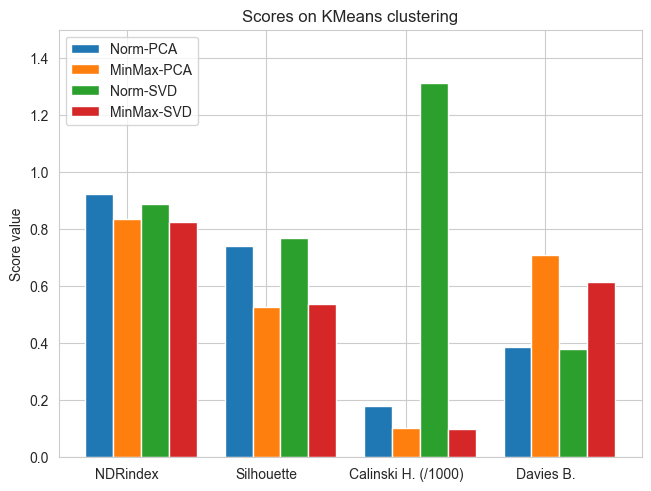

In [62]:
scores = ("NDRindex", "Silhouette", "Calinski H. (/1000)", "Davies B.")

clustering = {
    'Norm-PCA': (0.9222784254824972, 0.7406977052894916, 0.18126081236253583, 0.38786362447025535),
    'MinMax-PCA': (0.8368102223950831, 0.5284162034412085, 0.10310315823154086, 0.7083797481553313),
    'Norm-SVD': (0.8883059904088145, 0.7681567169698973, 1.3120210626412922, 0.38039978251738876),
    'MinMax-SVD' : (0.8245921933315248, 0.5373188166172057, 0.09931904094383715, 0.6137623707150898)
}

x = np.arange(len(scores))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in clustering.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score value')
ax.set_title('Scores on KMeans clustering')
ax.set_xticks(x + width, scores)
ax.legend(loc='upper left')
ax.set_ylim(0, 1.5)

plt.savefig("KMeans_scores")
plt.show()

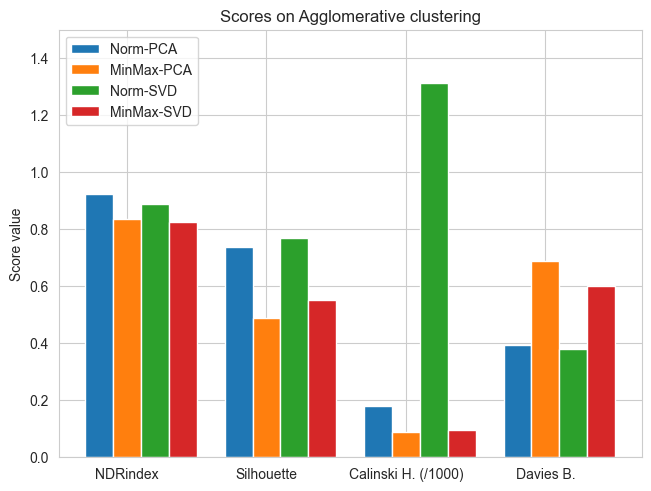

In [63]:
scores = ("NDRindex", "Silhouette", "Calinski H. (/1000)", "Davies B.")

clustering = {
    'Norm-PCA': (0.9222784254824972, 0.7377217960563341, 0.17966909793262775, 0.392446476723502),
    'MinMax-PCA': (0.8368102223950831, 0.48748701926440857, 0.08703315959699071, 0.6903001421318624),
    'Norm-SVD': (0.8883059904088145, 0.7681567169698973, 1.3120210626412922, 0.38039978251738876),
    'MinMax-SVD' : (0.8245921933315248, 0.5501534725572896, 0.0973025874930417, 0.5994025521189621)
}

x = np.arange(len(scores))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in clustering.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score value')
ax.set_title('Scores on Agglomerative clustering')
ax.set_xticks(x + width, scores)
ax.legend(loc='upper left')
ax.set_ylim(0, 1.5)

plt.savefig("Agglomerative_scores")
plt.show()